In [252]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import os

dir_path = current_directory = os.getcwd()

/Users/David/Documents/WORK/ARTICLES/CurrentWorks/SoftWalls_Jacobi


# Computation of spectrum for graphene with soft wall.

This is a companion code for the article *Edge states in 2d tight-binding models with soft walls*.

We take the notation of the article. We consider three different angles, "zigzag", "armchair", and "angle".
First, we record the parameters for these three angles.

In [229]:
name_cuts = ["zigzag", "armchair", "angle"]
param_cuts = {} # Dictionnary to record all paramaters

#########################
# Convention for zigzag.
#########################

t0 = 1 # hopping amplitude
a0 = 1 # lattice distance

#lattice vectors (zz for zigzag)
a1_zz = a0/2 * np.array([1, -np.sqrt(3)]) 
a2_zz = a0/2 * np.array([1,  np.sqrt(3)])

#dual lattice vectors
a1star_zz = 2*np.pi/np.sqrt(3)/a0 * np.array([np.sqrt(3), -1])
a2star_zz = 2*np.pi/np.sqrt(3)/a0 * np.array([np.sqrt(3),  1])

N = 2 # 2 carbon atoms per cell

# location of the atoms
x1 = 2/3*a1_zz + 1/3*a2_zz
x2 = 1/3*a1_zz + 2/3*a1_zz
pos_atoms = [x1, x2]

# The kernel h
# h[n,m] is the NxN matrix corresponding to h_{(n-1) a1 + (m-1) a2}
h = np.zeros((3, 3, N, N), dtype='complex128')
h[1,1,:,:] = t0 * np.array([[0, 1], [1,0]]) # h(0)
h[2,1,:,:] = t0 * np.array([[0, 0], [1,0]]) # h(a1)
h[1,2,:,:] = t0 * np.array([[0, 0], [1,0]]) # h(a2)
h[0,1,:,:] = t0 * np.array([[0, 1], [0,0]]) # h(-a1)
h[1,0,:,:] = t0 * np.array([[0, 1], [0,0]]) # h(-a2)

# we record all data in a dictionnary
param_cuts["zigzag"] = {"a1": a1_zz, "a2": a2_zz, "a1star" : a1star_zz, "a2star" : a2star_zz, "h": h, "N" : N, "pos_atoms" : pos_atoms}

#########################
# Convention for armchair.
#########################

n, m = -1, 1

# lattice vectors
a1 = n*a1_zz
a2 = n*a1_zz + m*a2_zz

# dual lattice vectors
a1star = a1star_zz/n - a2star_zz/m
a2star = a2star_zz/m

# It is not necessary to update N and xx, since they are similar to zigzag.

# The kernel h
h = np.zeros((3, 3, N, N), dtype='complex128')
h[1,1,:,:] = t0 * np.array([[0, 1], [1,0]]) # h(0)
h[2,1,:,:] = t0 * np.array([[0, 1], [0,0]]) # h(a1)
h[0,2,:,:] = t0 * np.array([[0, 1], [0,0]]) # h(a2-a1)
h[0,1,:,:] = t0 * np.array([[0, 0], [1,0]]) # h(-a1)
h[2,0,:,:] = t0 * np.array([[0, 0], [1,0]]) # h(a1-a2)

# we record all data in a dictionnary
param_cuts["armchair"] = {"a1": a1, "a2": a2, "a1star" : a1star, "a2star" : a2star, "h": h, "N" : N,  "pos_atoms" : pos_atoms}


#########################
# Convention for angle.
#########################

n, m = -1, 2

# lattice vectors
a1 = n*a1_zz
a2 = n*a1_zz + m*a2_zz

# dual lattice vectors
a1star = a1star_zz/n - a2star_zz/m
a2star = a2star_zz/m

N = 4 # 4 carbon atoms per cell

# location of the atoms
x1 = 2/3*a1_zz + 1/3*a2_zz
x2 = x1 + a2_zz 
x3 = 1/3*a1_zz + 2/3*a2_zz
x4 = x3 + a2_zz

pos_atoms = [x1, x2, x3, x4]

# The kernel h
#constructed with its upper-right component, called F

h = np.zeros((3, 3, N, N), dtype='complex128') 

F = np.zeros((3, 3, 2, 2), dtype='complex128') 
F[1, 1, :, :] = t0*np.array([[1, 0], [1, 1]])
F[2, 1, :, :] = t0*np.array([[1, 0], [0, 1]])
F[0, 2, :, :] = t0*np.array([[0, 1], [0, 0]])

for i in range(3):
	for j in range(3):
		h[i,j,:2, 2:] = F[i, j, :, :]
		h[i,j,2:, :2] = F[2-i, 2-j, :, :].transpose()

# we record all data in a dictionnary
param_cuts["angle"] = {"a1": a1, "a2": a2, "a1star" : a1star, "a2star" : a2star, "h": h, "N" : N, "pos_atoms" : pos_atoms}

In [254]:
def get_Hk(k, cut):
	'''
	Parameters:
	k : np.array of size 2
		k is a 2d vector in cartesian coordinates.
	cut : str
		must be "zigzag" or "armchair" or "angle"

	Returns:
	np.array 
		The NxN matrix H(k)
	''' 

	param = param_cuts[cut]
	a1, a2, h, N = param["a1"], param["a2"], param["h"], param["N"]

	Hk = np.zeros((N, N), dtype='complex128')

	# Hk is the Fourier transform of h, but there are only 9 non-zero elements
	for i in range(3):
		for j in range(3):
			R = (i-1)*a1 + (j-1)*a2
			Hk += h[i,j,:,:] * np.exp(-1j*np.dot(k, R))

	return Hk

In [255]:
def find_global_minimum(f, bounds, Ngrid = 20):
    # find the global minimum in two steps: 
    # - first evaluate where the minimum is
    # - then perform proper minimization.

    x_grid = np.linspace(bounds[0], bounds[1], Ngrid)
    f_grid = [f(x) for x in x_grid]

    best_x = x_grid[ np.argmin(f_grid) ]

    eps = (bounds[1] - bounds[0])/Ngrid

    return optimize.minimize_scalar(f, bounds=(best_x-eps, best_x+eps)).fun

In [264]:
def get_bulk_spectrum(k2, cut):
	'''
	Parameters:
	k2 : float
		k2 describes the k-vector k2*a2star.
	cut : str
		must be "zigzag" or "armchair" or "angle"

	Returns:
	float, float
		return two positive numbers a < b, such that the spectrum of H_{k2} is (-b,-a) ∪ (a,b).'''


	param = param_cuts[cut]
	a1star, a2star, N = param["a1star"], param["a2star"], param["N"]

	# find j-th eigenvalue
	def find_j_eigenvalue(k1, j=0):
		# create the vector k
		k = k1*a1star + k2*a2star

		# Compute the spectrum of H(k)
		Hk = get_Hk(k, cut)
		eigval, _ = np.linalg.eigh( Hk )
		eigval.sort()

		return eigval[j]
	
	# Find a rough approximation of a
	def find_a(k1): return find_j_eigenvalue(k1, j=N//2)
	def find_mb(k1): return find_j_eigenvalue(k1, j=0)
	
	# a is the N//2 lowest eigenvalue
	a = find_global_minimum(find_a, bounds=(0,1))
	# b is the opposite of the Oth eigenvalue.
	mb = find_global_minimum(find_mb, bounds=(0,1))
	
	return a, -mb

## The bulk spectra

We plot the bulk spectra for all three angles

In [266]:
# Example plots

# we compute the spectrum of H_{k2} for all k2 ∈ kk2. 
# Nk2 must be of the form 6n+1 to capture Dirac points

Nk2 = 6*25+1
kk2 = np.linspace(-1/2, 1/2, Nk2)

results_σ_bulk = {} #to record all results

# Loop for all cuts
for cut in name_cuts:
    
    # We record the essential spectrum as a function of k2
    min_σ_ess = np.empty(Nk2)
    max_σ_ess = np.empty(Nk2)
    
    for ik2, k2 in enumerate(kk2):
        # find and record the essential spectrum
        a, b = get_bulk_spectrum(k2, cut)
        min_σ_ess[ik2] = a
        max_σ_ess[ik2] = b
    
    # record the results
    results_σ_bulk[cut] = {"kk2": kk2, "min_σ_ess": min_σ_ess, "max_σ_ess": max_σ_ess}

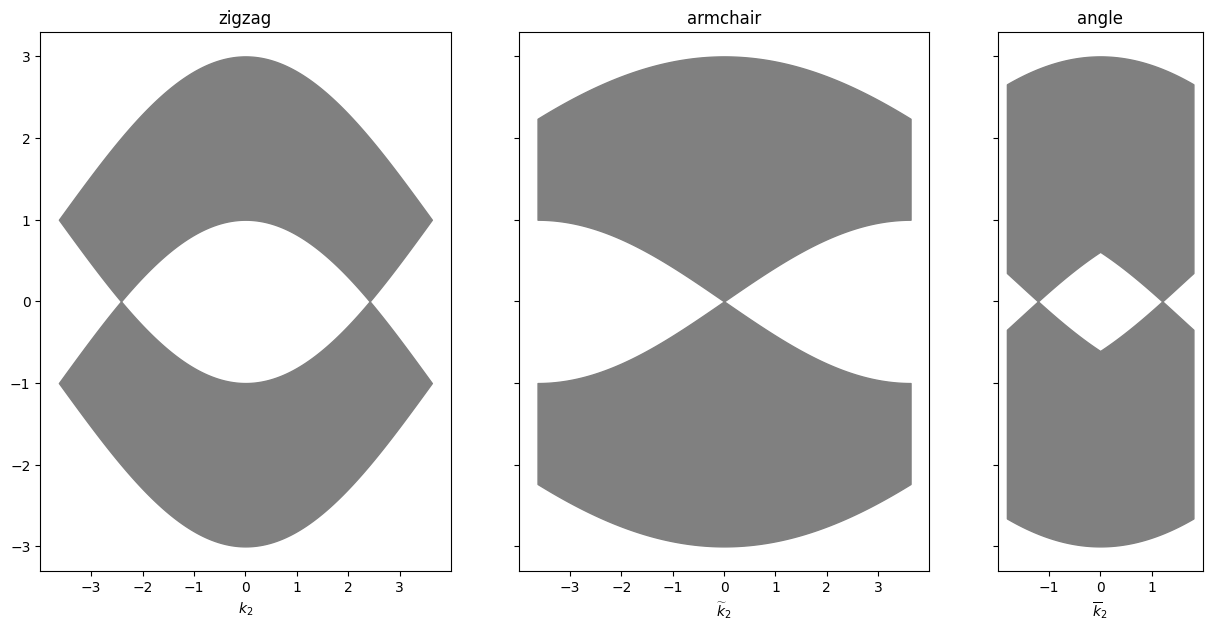

In [270]:
# Plot the results

# We create a subplot, with different size, to reflect that the angle cut is on a twice smaller interval
width_ratios = [2,2,1]
fig, ax = plt.subplots(1, 3, sharey = True, figsize=(15,7), width_ratios=width_ratios)
xlabels = ["$k_2$", "$\widetilde{k}_2$", "$\overline{k}_2$"]

for i, cut in enumerate( name_cuts ):
    
    σ_bulk = results_σ_bulk[cut]
    kk2, min_σ_ess, max_σ_ess = σ_bulk["kk2"], σ_bulk["min_σ_ess"], σ_bulk["max_σ_ess"]

    # plot grey area for the bulk spectrum.
    # we scale appropriately the x_axis
    param = param_cuts[cut]
    a2star = param["a2star"]

    ax[i].fill_between(np.linalg.norm(a2star)*kk2, min_σ_ess, max_σ_ess, color='grey')
    ax[i].fill_between(np.linalg.norm(a2star)*kk2, -max_σ_ess, -min_σ_ess, color='grey')

    ax[i].set_xlabel( xlabels[i] )
    ax[i].set_title(cut)

savefig("pictures/bulk_spectra.png", bbox_inches="tight", dpi=200)
plt.show()

## Edge spectrum

We now compute the spectrum of the edge operators. To do so, we fix k2, and compute H_{k2} as a Jacobi operators.

We put Dirichlet boundary conditions at the boundary (we will remove the spurious edge modes created by this boundary later).

In [271]:
# First,we compute the bulk Hamiltonian H_{k2} as a Jacobi operator

def get_Hk2_Jacobi(k2, L, cut):
	'''
	Parameters:
	k2 : float
		k2 represents the vector k2*a2star
	L : int
		L is the size of the block matrix. The total matrix will be of size L*N
	param : dict
		dictionnary describing the angle

	Returns:
	np.array 
		The (LN)x(LN) matrix H_{k2} as a Jacobi operator
	'''
	
	param = param_cuts[cut]
	h, N = param["h"], param["N"]
	
	# The jacobi matrix elements

	# b = h[0] + h[a2] exp(-i k2.a2 ) + h[-a2] exp(i k2.a2)
	Bk2 = h[1,1,:,:] + h[1,2,:,:]*np.exp(-1j*2*np.pi*k2) + h[1,0,:,:]*np.exp(1j*2*np.pi*k2)

	# a = h[-a1] + h[-a1 + a2] exp(-i k2.a2) + h[-a1-a2] exp(i k2.a2)
	Ak2 = h[0,1,:,:] + h[0,2,:,:]*np.exp(-1j*2*np.pi*k2) + h[0,0,:,:]*np.exp(1j*2*np.pi*k2)

	#We fill the matrix  
	H = np.zeros((N*L, N*L), dtype="complex")

	for i in range(L):
		H[N*i:N*i+N, N*i:N*i+N] = Bk2
	for i in range(L-1):
		H[N*i+N:N*i+2*N, N*i:N*i+N] = Ak2
		H[N*i:N*i+N, N*i+N:N*i+2*N] = Ak2.transpose()
	
	return H

In [279]:
# Next, we compute the wall operator with the same convention.

# the one-dimensional wall
def w1(x, ν = 1): return ν*maximum(-x, 0)

def get_Wt(t, L, cut, ν = 1):

    param = param_cuts[cut]
    a1, a1star, N, pos_atoms = param["a1"], param["a1star"], param["N"], param["pos_atoms"]
    a1perp = a1star/norm(a1star) #perpendicular vector

    W = zeros((N*L, N*L))
    for i in range(L):
        W[N*i:N*i+N, N*i:N*i+N] = np.diag([w1(np.dot(a1perp, xi + (i-L//2-t)*a1), ν = ν) for xi in pos_atoms])
    return W

In [280]:
# The edge Hamiltonian 
def get_Hedge_k2_t(k2, t, L, cut, ν = 1):
    H0k = get_Hk2_Jacobi(k2, L, cut)
    Wt = get_Wt(t, L, cut, ν = ν)
    return H0k + Wt

## Plot of the spectrum for a specific value of t.

In [392]:
def get_edge_modes(t, L, cut, Nk2, ν = 1, verbose = True):

    filename = dir_path+"/Data/"+"edge_modes_{}_t{:d}_L{}_Nk2{}_nu{}.npy".format(cut, int(100*t), L, Nk2, ν)

    # Check if the computation has been done already
    if verbose: print("filename = ", filename)

    if os.path.exists(filename):
        results = np.load(filename, allow_pickle=True).item()
        if verbose: print("file already exists.")
        return results
    
    # Else we make the computation
    else:
        if verbose: print("Computation for t = {}, L = {}, Nk2 = {}, cut = {}".format(t, L, Nk2, cut))

        param = param_cuts[cut]
        N = param["N"]
        kk2 = np.linspace(-1/2, 1/2, Nk2)

        # record eigenvalue
        eigval_record = np.empty((Nk2, N*L))
        # check if it is an edge mode
        edge_modes = np.empty((Nk2, N*L))

        for ik2, k2 in enumerate(kk2):

            Hedge = get_Hedge_k2_t(k2, t, L, cut, ν = ν)
            eigval, eigvec = np.linalg.eigh(Hedge)

            eigval_record[ik2, :] = eigval
            edge_modes[ik2, :] = eigval

            # We check if the eigenpair corresponds to an edge mode
            min_σ_ess, max_σ_ess = get_bulk_spectrum(k2, cut)

            for n in range(N*L):
                # check if localized
                if sum( abs(eigvec[:, n])[int(L*N/4):int(3*L*N/4)]**2) < 1/2 :
                    edge_modes[ik2,n] = nan
            
                # check if not in the essential spectrum
                if abs( eigval[n] ) > min_σ_ess and abs( eigval[n] ) < max_σ_ess: 
                    edge_modes[ik2,n] = nan

         # save results
        results = {"cut": cut, "t": t, "L": L, "Nk2": Nk2, "nu": ν, "eigval": eigval_record, "edge_modes": edge_modes}
        np.save(filename, results)

        return results

In [395]:
###############
# Parameters
############### 

Nk2 = 6*25+1 # must be 6n+1 to capture the Dirac cones
#t = 0.4
ν = 1
L = 200

# We make the computations, and store  the results
for t in np.linspace(0, 1, 11):
    for cut in name_cuts :
        results = get_edge_modes(t, L, cut, Nk2, verbose = False)

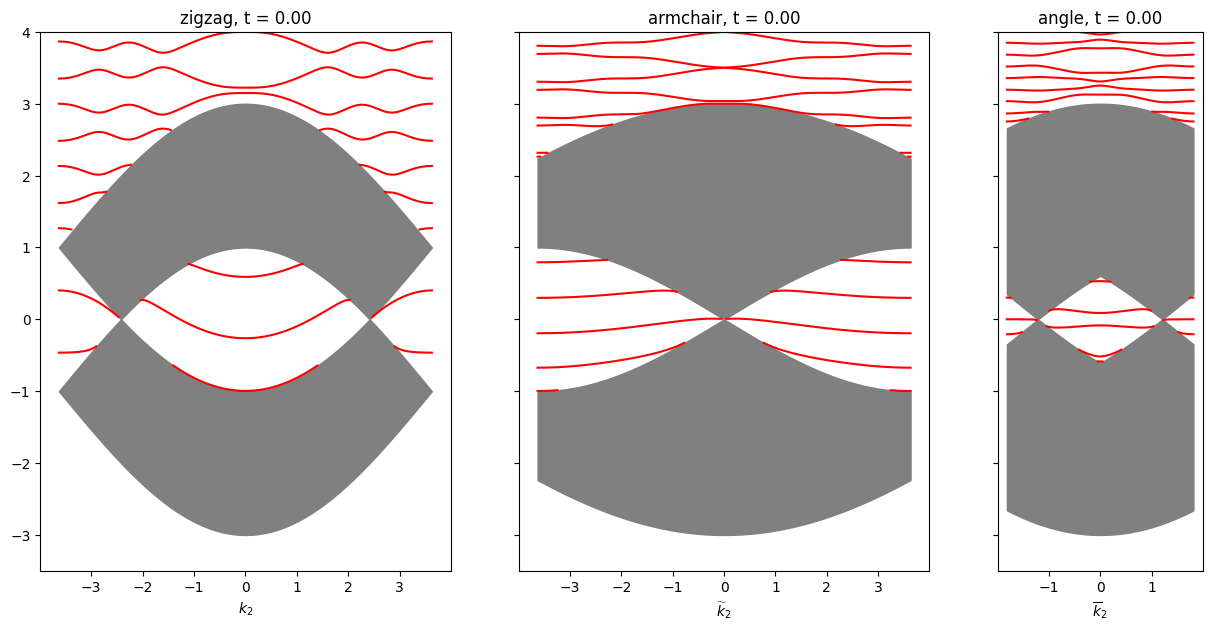

In [394]:
# PLOTS
# We create a subplot, with different size, to reflect that the angle cut is on a twice smaller interval

t = 0

width_ratios = [2,2,1]
fig, ax = plt.subplots(1, 3, sharey = True, figsize=(15,7), width_ratios=width_ratios)
xlabels = ["$k_2$", "$\widetilde{k}_2$", "$\overline{k}_2$"]

for i, cut in enumerate( name_cuts ):
    # Bulk spectrum
    σ_bulk = results_σ_bulk[cut]
    kk2, min_σ_ess, max_σ_ess = σ_bulk["kk2"], σ_bulk["min_σ_ess"], σ_bulk["max_σ_ess"]

    # plot grey area for the bulk spectrum.
    # we scale appropriately the x_axis
    param = param_cuts[cut]
    a2star = param["a2star"]

    ax[i].fill_between(np.linalg.norm(a2star)*kk2, min_σ_ess, max_σ_ess, color='grey')
    ax[i].fill_between(np.linalg.norm(a2star)*kk2, -max_σ_ess, -min_σ_ess, color='grey')

    # Edge spectrum
    results =  get_edge_modes(t, L, cut, Nk2, ν, verbose=False)
    edge_modes = results["edge_modes"]

    ax[i].plot(np.linalg.norm(a2star)*kk2, edge_modes, 'r')

    # labels
    ax[i].set_xlabel( xlabels[i] )
    ax[i].set_title("{}, t = {:.2f}".format(cut, t))
    ax[i].set_ylim(-3.5, 4)

savefig("pictures/edge_spectra_t{:d}_L_{}_nu{}.png".format(int(100*t), L, ν), bbox_inches="tight", dpi=200)

## Pictures for k2 fixed, and all t

In [397]:
def get_edge_modes_fixedk2_allt(Nt, L, cut, k2, ν = 1, verbose = True):
    '''
    Parameters:
    Nt: int
        the number of t values
    L: int
        the size of the matrices
    cut: str
        the cut, must be zigzag, armchair or angle
    k2: float
        the specific value of k2
        reprensents the vector k2*a2star
    ν: float
        the Lipschitz constant (defauts is ν = 1).
    '''


    filename = dir_path+"/Data/"+"Sf_Graphene_{}_Nt{:d}_L{}_k2{}_nu{}.npy".format(cut, Nt, L, int(10*k2), ν)
    if verbose: print("filename: ", filename)

    # Check if the computation has been done already
    if os.path.exists(filename):
        results = np.load(filename, allow_pickle=True).item()
        return results
    
    # Else we make the computation
    else:
        if verbose: print("Computation for Nt = {}, L = {}, k2 = {}, cut = {}".format(Nt, L, k2, cut))

        param = param_cuts[cut]
        N = param["N"]
        tt = np.linspace(0, 1, Nt)

        # the essential spectrum
        min_σ_ess, max_σ_ess = get_bulk_spectrum(k2, cut)

        # record eigenvalue
        eigval_record = np.empty((Nt, N*L))
        # check if it is an edge mode
        edge_modes = np.empty((Nt, N*L))

        for it, t in enumerate(tt):

            Hedge = get_Hedge_k2_t(k2, t, L, cut, ν = ν)
            eigval, eigvec = np.linalg.eigh(Hedge)

            eigval_record[it, :] = eigval
            edge_modes[it, :] = eigval

            # We check if the eigenpair corresponds to an edge mode

            for n in range(N*L):
                # check if localized
                if sum( abs(eigvec[:, n])[int(L*N/4):int(3*L*N/4)]**2) < 1/2 :
                    edge_modes[it,n] = nan
            
                # check if not in the essential spectrum
                if abs( eigval[n] ) > min_σ_ess and abs( eigval[n] ) < max_σ_ess: 
                    edge_modes[it,n] = nan

         # save results
        results = {"cut": cut, "Nt": Nt, "L": L, "k2": k2, "nu": ν, "eigval": eigval_record, "edge_modes": edge_modes}
        np.save(filename, results)

        return results

In [401]:
###############
# Parameters
############### 

Nt = 100
k2 = 1/6
ν = 0.5
L = 200

# We make the computations, and store  the results
for cut in name_cuts :
    #print("computation for ", cut)
    results = get_edge_modes_fixedk2_allt(Nt, L, cut, k2, verbose = False)

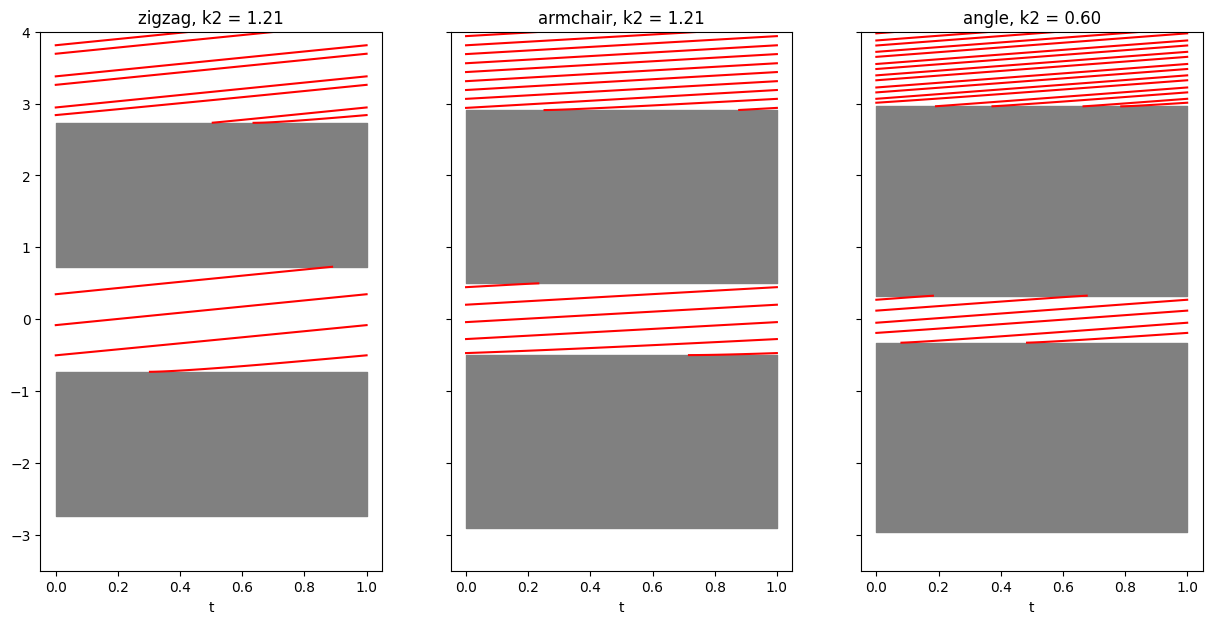

In [402]:
# PLOTS
width_ratios = [1,1,1]
fig, ax = plt.subplots(1, 3, sharey = True, figsize=(15,7), width_ratios=width_ratios)

for i, cut in enumerate( name_cuts ):

    # Bulk spectrum
    σ_bulk = results_σ_bulk[cut]
    min_σ_ess, max_σ_ess = get_bulk_spectrum(k2, cut)

    ax[i].fill_between([0, 1], [min_σ_ess, min_σ_ess], [max_σ_ess, max_σ_ess], color='grey')
    ax[i].fill_between([0, 1], [-min_σ_ess, -min_σ_ess], [-max_σ_ess, -max_σ_ess], color='grey')


    # Edge spectrum
    results =  get_edge_modes_fixedk2_allt(Nt, L, cut, k2, ν, verbose = False)
    edge_modes = results["edge_modes"]

    tt = np.linspace(0, 1, Nt)
    ax[i].plot(tt, edge_modes, 'r')

    # labels
    param = param_cuts[cut]
    a2star = param["a2star"]

    ax[i].set_xlabel( "t" )
    ax[i].set_title("{}, k2 = {:.2f}".format(cut, np.linalg.norm(k2*a2star)))
    ax[i].set_ylim(-3.5, 4)

savefig("pictures/Sf_graphene_k2{}_L_{}_nu{}.png".format(int(100*k2), L, ν), bbox_inches="tight", dpi=200)